### PeakGuard — Energy Consumption Time Series (GRU RNN)

This notebook loads the Energy Consumption Time Series Dataset (Kwh Consumption Blower 78) and trains a Gated Recurrent Unit (GRU) recurrent neural network to forecast short-term consumption.

Steps:
- Load and merge CSVs from `data/`
- Parse timestamps and clean data
- Resample to hourly frequency and interpolate missing values
- Create supervised sequences with a sliding window
- Split into train/validation/test sets by time
- Scale features, train a GRU model, and evaluate
- Plot predictions vs. ground truth


In [1]:
# If running in a clean environment, uncomment the following to install deps
# %pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow==2.15.0

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

DATA_DIR = os.path.join(os.getcwd(), 'data')
CSV_FILES = sorted(glob.glob(os.path.join(DATA_DIR, 'KwhConsumptionBlower78_*.csv')))
CSV_FILES


2.19.0


['/Users/andressalguero/Documents/lambton/3104_Neural_Networks_and_Deep_Learning/classes/data/KwhConsumptionBlower78_1.csv',
 '/Users/andressalguero/Documents/lambton/3104_Neural_Networks_and_Deep_Learning/classes/data/KwhConsumptionBlower78_2.csv',
 '/Users/andressalguero/Documents/lambton/3104_Neural_Networks_and_Deep_Learning/classes/data/KwhConsumptionBlower78_3.csv']

In [2]:
def load_and_concat(csv_paths: list[str]) -> pd.DataFrame:
    frames = []
    for path in csv_paths:
        df = pd.read_csv(path)
        # Handle optional unnamed index column
        if df.columns[0].lower().startswith('unnamed'):
            df = df.drop(columns=[df.columns[0]])
        # Standardize column names
        df.columns = [c.strip() for c in df.columns]
        # Parse datetime
        # Kaggle format: TxnDate like '01 Jan 2022', TxnTime like '16:55:52'
        ts = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'], dayfirst=True, errors='coerce')
        df = pd.DataFrame({
            'timestamp': ts,
            'consumption': pd.to_numeric(df['Consumption'], errors='coerce')
        })
        frames.append(df)
    out = pd.concat(frames, ignore_index=True)
    out = out.dropna(subset=['timestamp', 'consumption'])
    out = out.sort_values('timestamp').reset_index(drop=True)
    return out

raw_df = load_and_concat(CSV_FILES)
raw_df.head(), raw_df.tail(), raw_df.shape


(            timestamp  consumption
 0 2022-01-01 00:22:28        1.030
 1 2022-01-01 00:42:33        0.904
 2 2022-01-01 01:01:51        0.904
 3 2022-01-01 01:41:48        1.850
 4 2022-01-01 02:22:52        1.878,
                timestamp  consumption
 3601 2022-02-28 22:25:43        1.152
 3602 2022-02-28 22:44:37        0.888
 3603 2022-02-28 23:07:15        1.064
 3604 2022-02-28 23:29:13        1.036
 3605 2022-02-28 23:50:27        1.000,
 (3606, 2))

2022-01-01 00:22:28 -> 2022-02-28 23:50:27
Rows: 3606 Nulls: {'timestamp': 0, 'consumption': 0}


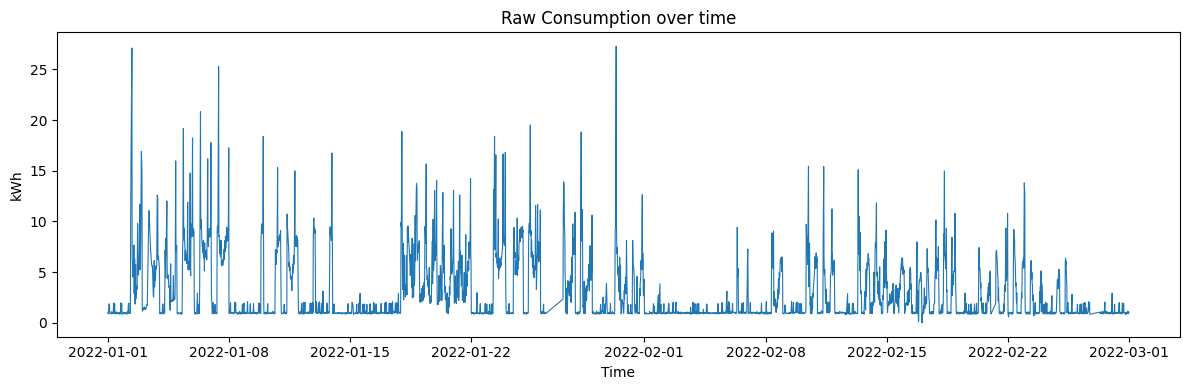

In [3]:
# Basic EDA
print(raw_df['timestamp'].min(), '->', raw_df['timestamp'].max())
print('Rows:', len(raw_df), 'Nulls:', raw_df.isna().sum().to_dict())

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(raw_df['timestamp'], raw_df['consumption'], lw=0.8)
ax.set_title('Raw Consumption over time')
ax.set_xlabel('Time')
ax.set_ylabel('kWh')
plt.tight_layout()
plt.show()


In [4]:
# Resample to hourly frequency and fill gaps

ts = raw_df.set_index('timestamp').sort_index()
# Some timestamps are irregular; aggregate to hour using mean
hourly = ts.resample('1H').mean(numeric_only=True)
# Fill interior missing values by time interpolation
hourly['consumption'] = hourly['consumption'].interpolate(method='time').ffill().bfill()

hourly.head(), hourly.tail(), hourly.isna().sum()


/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_50795/3737203224.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = ts.resample('1H').mean(numeric_only=True)


(                     consumption
 timestamp                       
 2022-01-01 00:00:00     0.967000
 2022-01-01 01:00:00     1.377000
 2022-01-01 02:00:00     1.485000
 2022-01-01 03:00:00     0.929333
 2022-01-01 04:00:00     0.922667,
                      consumption
 timestamp                       
 2022-02-28 19:00:00     0.968000
 2022-02-28 20:00:00     0.932000
 2022-02-28 21:00:00     0.960000
 2022-02-28 22:00:00     1.020000
 2022-02-28 23:00:00     1.033333,
 consumption    0
 dtype: int64)

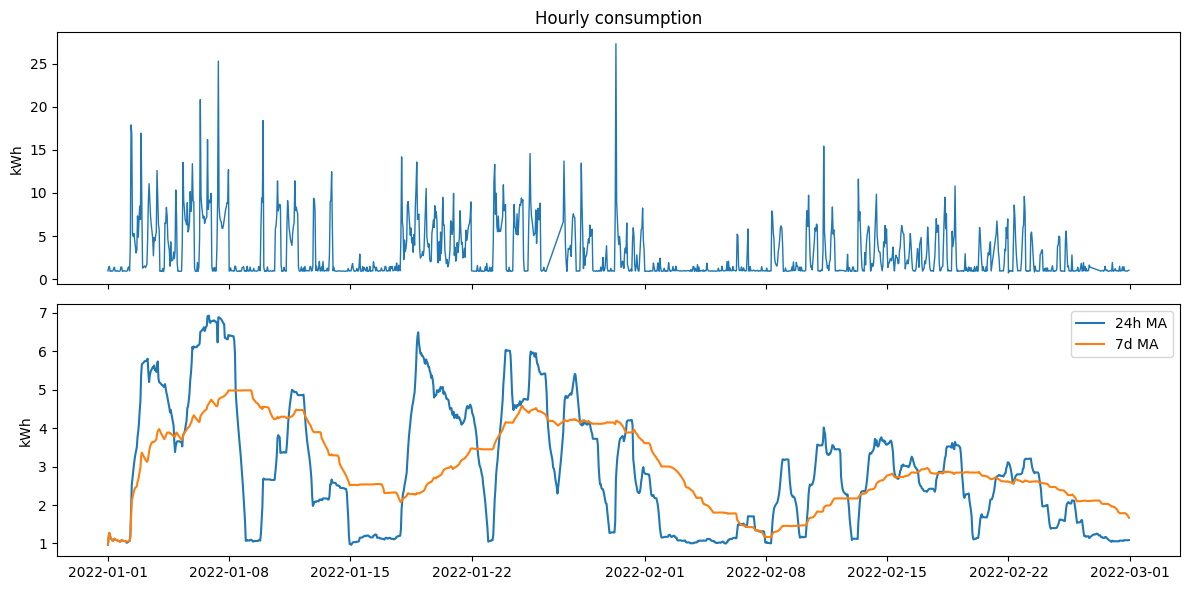

In [5]:
# Visualize hourly series
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(hourly.index, hourly['consumption'], lw=1.0)
ax[0].set_title('Hourly consumption')
ax[0].set_ylabel('kWh')

# Rolling statistics for trend/seasonality hint
ax[1].plot(hourly.index, hourly['consumption'].rolling(24, min_periods=1).mean(), label='24h MA')
ax[1].plot(hourly.index, hourly['consumption'].rolling(24*7, min_periods=1).mean(), label='7d MA')
ax[1].legend()
ax[1].set_ylabel('kWh')

plt.tight_layout()
plt.show()


In [6]:
# Create supervised sequences (window -> next-step forecast)
from typing import Tuple

def create_sequences(values: np.ndarray, window_size: int = 24, horizon: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(values) - window_size - horizon + 1):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size:i+window_size+horizon])
    X = np.array(X)
    y = np.array(y)  # shape: (samples, horizon)
    # Reshape to (samples, timesteps, features) for RNN input
    X = X[..., np.newaxis]
    return X, y

series = hourly['consumption'].astype(float).values
window_size = 24
horizon = 1
X_all, y_all = create_sequences(series, window_size=window_size, horizon=horizon)
X_all.shape, y_all.shape


((1392, 24, 1), (1392, 1))

In [7]:
# Time-based split: 70% train, 15% val, 15% test
num_samples = len(X_all)
train_end = int(num_samples * 0.7)
val_end = int(num_samples * 0.85)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val     = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test   = X_all[val_end:], y_all[val_end:]

X_train.shape, X_val.shape, X_test.shape


((974, 24, 1), (209, 24, 1), (209, 24, 1))

In [8]:
# Prefer scaling the raw series once, then windowing to keep target consistency
series_scaler = MinMaxScaler()
series_scaled = series_scaler.fit_transform(series.reshape(-1, 1)).reshape(-1)

X_all_s, y_all_s = create_sequences(series_scaled, window_size=window_size, horizon=horizon)

X_train_s2, y_train_s2 = X_all_s[:train_end], y_all_s[:train_end]
X_val_s2, y_val_s2     = X_all_s[train_end:val_end], y_all_s[train_end:val_end]
X_test_s2, y_test_s2   = X_all_s[val_end:], y_all_s[val_end:]

X_train_s2.shape, y_train_s2.shape


((974, 24, 1), (974, 1))

In [9]:
# Build GRU model
keras.utils.set_random_seed(42)

model = keras.Sequential([
    layers.Input(shape=(window_size, 1)),
    layers.GRU(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(horizon)  # output horizon steps
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_rmse'),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

history = model.fit(
    X_train_s2, y_train_s2,
    validation_data=(X_val_s2, y_val_s2),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

pd.DataFrame(history.history).tail()


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0150 - rmse: 0.1221 - val_loss: 0.0048 - val_rmse: 0.0695 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - rmse: 0.0992 - val_loss: 0.0044 - val_rmse: 0.0665 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0041 - val_rmse: 0.0644 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - rmse: 0.0954 - val_loss: 0.0040 - val_rmse: 0.0632 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0038 - val_rmse: 0.0616 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0036 - val_rmse: 0.0604 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0035 - val_rmse: 0.0589 - learning_rate: 0.001

,loss,rmse,val_loss,val_rmse,learning_rate
18,0.006347,0.079665,0.003511,0.059257,0.00050
19,0.006597,0.081225,0.003423,0.058503,0.00050
20,0.006601,0.081248,0.003512,0.059261,0.00050
21,0.006404,0.080022,0.003529,0.059409,0.00025
22,0.006438,0.080240,0.003476,0.058956,0.00025


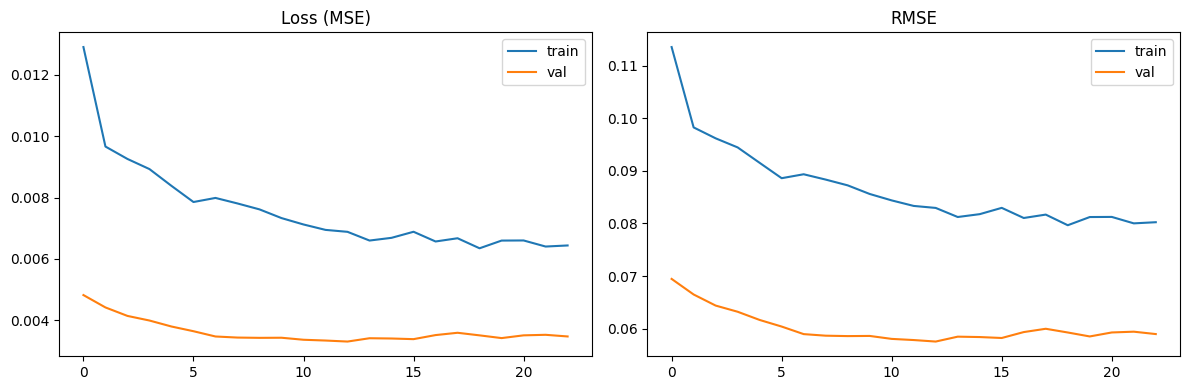

In [11]:
# Plot learning curves
hist = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist['loss'], label='train')
ax[0].plot(hist['val_loss'], label='val')
ax[0].set_title('Loss (MSE)')
ax[0].legend()

ax[1].plot(hist['rmse'], label='train')
ax[1].plot(hist['val_rmse'], label='val')
ax[1].set_title('RMSE')
ax[1].legend()
plt.tight_layout()
plt.show()


In [12]:
# Evaluate on test set (in scaled space)
test_metrics = model.evaluate(X_test_s2, y_test_s2, verbose=0, return_dict=True)
test_metrics


{'loss': 0.0020083484705537558, 'rmse': 0.04481460154056549}

In [13]:
# Predict and inverse scale for interpretability
pred_scaled = model.predict(X_test_s2)
true_scaled = y_test_s2

# Inverse transform: need 2D for scaler
pred = series_scaler.inverse_transform(pred_scaled)
true = series_scaler.inverse_transform(true_scaled)

pred[:5].ravel(), true[:5].ravel()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


(array([1.2348024, 3.8776863, 6.353782 , 5.496273 , 3.4769592],
       dtype=float32),
 array([3.632     , 6.00533333, 4.988     , 3.188     , 1.85733333]))

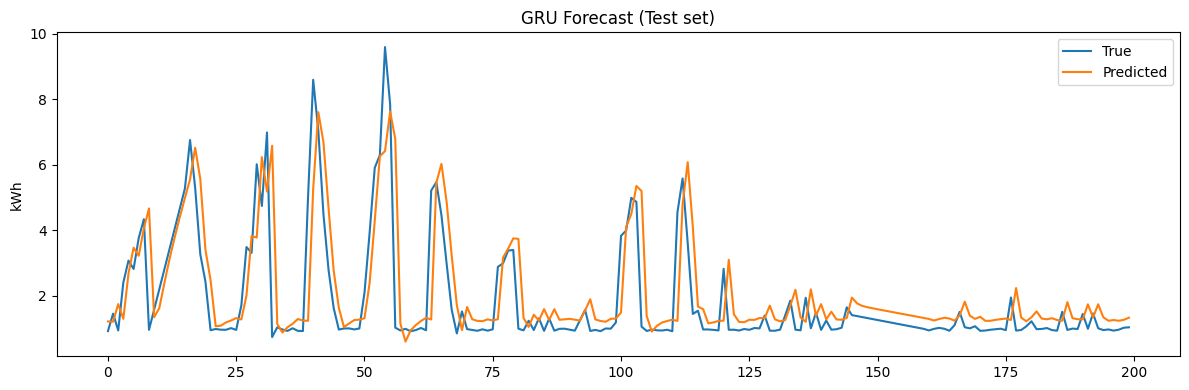

In [14]:
# Plot predictions vs ground truth for a recent window
n_plot = 200
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(true.ravel()[-n_plot:], label='True')
ax.plot(pred.ravel()[-n_plot:], label='Predicted')
ax.set_title('GRU Forecast (Test set)')
ax.set_ylabel('kWh')
ax.legend()
plt.tight_layout()
plt.show()


In [14]:
# Save model, weights, and scaler
save_dir = 'artifacts'
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, 'gru_energy_forecaster.keras'))
# Also save weights for deployment environments that prefer weight loading
model.save_weights(os.path.join(save_dir, 'gru_energy_forecaster.weights.h5'))
import joblib
joblib.dump(series_scaler, os.path.join(save_dir, 'series_minmax_scaler.pkl'))

print('Saved to', os.path.abspath(save_dir))


Saved to /Users/andressalguero/Documents/lambton/3104_Neural_Networks_and_Deep_Learning/classes/artifacts


In [15]:
import joblib


def prepare_hourly_from_kaggle_like(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Accept either Kaggle-like columns or already parsed
    if {'TxnDate', 'TxnTime', 'Consumption'}.issubset(df.columns):
        ts = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'], dayfirst=True, errors='coerce')
        vals = pd.to_numeric(df['Consumption'], errors='coerce')
        tmp = pd.DataFrame({'timestamp': ts, 'consumption': vals}).dropna()
    elif {'timestamp', 'consumption'}.issubset(df.columns):
        tmp = df[['timestamp', 'consumption']].dropna()
        tmp['timestamp'] = pd.to_datetime(tmp['timestamp'], errors='coerce')
        tmp = tmp.dropna()
    else:
        raise ValueError('Input DataFrame must contain Kaggle-like columns (TxnDate, TxnTime, Consumption) or (timestamp, consumption).')

    hourly = tmp.set_index('timestamp').sort_index().resample('1H').mean(numeric_only=True)
    hourly['consumption'] = hourly['consumption'].interpolate(method='time').ffill().bfill()
    return hourly


def predict_next_horizon_from_raw(
    raw_df: pd.DataFrame,
    model_path: str,
    scaler_path: str,
    window_size: int = 24,
    horizon: int = 1,
) -> pd.DataFrame:
    """
    Load model and scaler, preprocess raw Kaggle-like data to hourly, create sliding windows,
    and return a DataFrame with timestamps, predictions, and (if available) ground truth.
    """
    mdl = keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)

    hourly = prepare_hourly_from_kaggle_like(raw_df)
    series = hourly['consumption'].astype(float).values

    # Scale with the saved scaler
    series_scaled = scaler.transform(series.reshape(-1, 1)).reshape(-1)

    X, y = create_sequences(series_scaled, window_size=window_size, horizon=horizon)
    preds_scaled = mdl.predict(X, verbose=0)

    # Inverse transform to original kWh
    preds = scaler.inverse_transform(preds_scaled)
    y_true = scaler.inverse_transform(y) if y is not None and len(y) == len(preds) else None

    # Align timestamps; for each i, target time is index i+window_size (for horizon=1)
    target_times = hourly.index[window_size:window_size + len(preds)]

    out = pd.DataFrame({'timestamp': target_times, 'y_pred': preds.ravel()})
    if y_true is not None:
        out['y_true'] = y_true.ravel()
    return out


def generate_synthetic_consumption(
    start: str,
    periods: int,
    freq: str = 'H',
    seed: int = 42,
    base_level: float | None = None,
    daily_amplitude: float | None = None,
    weekly_amplitude: float | None = None,
    noise_std: float | None = None,
    spike_probability: float = 0.01,
    spike_scale: float = 3.0,
    reference_hourly: pd.Series | None = None,
) -> pd.DataFrame:
    """
    Create a synthetic consumption time series with daily/weekly seasonality, noise, and occasional spikes.
    Returns DataFrame with Kaggle-like columns: TxnDate, TxnTime, Consumption.
    """
    rng = np.random.default_rng(seed)

    # Infer sensible defaults from reference series if provided
    if reference_hourly is not None and len(reference_hourly) > 0:
        ref_mean = float(np.nanmean(reference_hourly.values))
        ref_std = float(np.nanstd(reference_hourly.values))
        base_level = ref_mean if base_level is None else base_level
        daily_amplitude = (0.15 * ref_mean) if daily_amplitude is None else daily_amplitude
        weekly_amplitude = (0.08 * ref_mean) if weekly_amplitude is None else weekly_amplitude
        noise_std = (0.5 * ref_std) if noise_std is None else noise_std
    else:
        base_level = 1.0 if base_level is None else base_level
        daily_amplitude = 0.15 if daily_amplitude is None else daily_amplitude
        weekly_amplitude = 0.08 if weekly_amplitude is None else weekly_amplitude
        noise_std = 0.1 if noise_std is None else noise_std

    idx = pd.date_range(start=start, periods=periods, freq=freq)
    t = np.arange(periods)

    # Seasonality
    daily = np.sin(2 * np.pi * t / 24.0)
    weekly = np.sin(2 * np.pi * t / (24.0 * 7.0))

    # AR(1)-like noise for temporal smoothness
    eps = rng.normal(0.0, noise_std, size=periods)
    ar = np.zeros(periods)
    phi = 0.6
    for i in range(1, periods):
        ar[i] = phi * ar[i - 1] + eps[i]

    # Spikes
    spikes = (rng.random(periods) < spike_probability).astype(float)
    spikes *= rng.lognormal(mean=0.0, sigma=0.5, size=periods) * spike_scale

    values = base_level + daily_amplitude * daily + weekly_amplitude * weekly + ar + spikes
    values = np.clip(values, a_min=0.0, a_max=None)

    out = pd.DataFrame({'timestamp': idx, 'consumption': values})
    out['TxnDate'] = out['timestamp'].dt.strftime('%d %b %Y')
    out['TxnTime'] = out['timestamp'].dt.strftime('%H:%M:%S')
    out['Consumption'] = out['consumption'].astype(float)
    return out[['TxnDate', 'TxnTime', 'Consumption']]


In [30]:
# Example: generate synthetic data and run prediction with saved artifacts

# 1) Generate 30 days of hourly synthetic data (periods=24*30)
synth_df_30 = generate_synthetic_consumption(
    start='2022-03-01 00:00:00',
    periods=24 * 30,
    freq='H',
    seed=123,
    reference_hourly=hourly['consumption'] if 'hourly' in globals() else None,
)

/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_13668/343285522.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(start=start, periods=periods, freq=freq)


### Deployment note (FastAPI)

After training, the following artifacts are saved to `artifacts/`:
- `gru_energy_forecaster.keras`
- `gru_energy_forecaster.weights.h5` (new)
- `series_minmax_scaler.pkl`

If a runtime cannot deserialize the `.keras` model due to Keras/TF version differences, use the weights fallback:
- Copy `gru_energy_forecaster.weights.h5` and `series_minmax_scaler.pkl` to your API project `artifacts/`.
- The API will reconstruct the model architecture and load weights automatically.


In [32]:
print(synth_df_30.shape)

(720, 3)


In [21]:
def forecast_next_hours(
    raw_df: pd.DataFrame,
    model_path: str,
    scaler_path: str,
    window_size: int = 24,
    steps: int = 24,
) -> pd.DataFrame:
    """
    Forecast the next `steps` hourly consumption values using an autoregressive loop
    with a 1-step-ahead GRU model. Returns a DataFrame with future timestamps and predictions (kWh).
    """
    mdl = keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)

    hourly = prepare_hourly_from_kaggle_like(raw_df)
    series = hourly['consumption'].astype(float).values

    # Scale
    series_scaled = scaler.transform(series.reshape(-1, 1)).reshape(-1)

    if len(series_scaled) < window_size:
        raise ValueError(f"Not enough history: need at least window_size={window_size} points, got {len(series_scaled)}")

    # Seed window from last `window_size` points
    window = series_scaled[-window_size:].astype(float).copy()
    preds_scaled = []

    for _ in range(steps):
        x = window.reshape(1, window_size, 1)
        yhat = mdl.predict(x, verbose=0).ravel()[0]
        preds_scaled.append(yhat)
        # shift left and append prediction
        window[:-1] = window[1:]
        window[-1] = yhat

    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    preds = scaler.inverse_transform(preds_scaled).ravel()

    start_time = hourly.index[-1] + pd.Timedelta(hours=1)
    future_index = pd.date_range(start=start_time, periods=steps, freq='H')

    return pd.DataFrame({'timestamp': future_index, 'y_pred': preds})


In [22]:
# Example: forecast next 24 hours from synthetic recent data
synth_df = generate_synthetic_consumption(
    start='2022-04-01 00:00:00',
    periods=24*14,
    freq='H',
    seed=202,
    reference_hourly=hourly['consumption'] if 'hourly' in globals() else None,
)

/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_13668/343285522.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(start=start, periods=periods, freq=freq)


In [27]:
synth_df.head()
print(synth_df.shape)

(336, 3)


In [ ]:
art_dir = 'artifacts'
model_path = os.path.join(art_dir, 'gru_energy_forecaster.keras')
scaler_path = os.path.join(art_dir, 'series_minmax_scaler.pkl')

future_24h = forecast_next_hours(
    raw_df=synth_df,
    model_path=model_path,
    scaler_path=scaler_path,
    window_size=24,
    steps=24,
)

future_24h.head()


/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_13668/343285522.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = tmp.set_index('timestamp').sort_index().resample('1H').mean(numeric_only=True)
/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_13668/935020661.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=start_time, periods=steps, freq='H')


,timestamp,y_pred
0,2022-04-15 00:00:00,3.928517
1,2022-04-15 01:00:00,4.194951
2,2022-04-15 02:00:00,4.463192
3,2022-04-15 03:00:00,4.723674
4,2022-04-15 04:00:00,4.967088


In [ ]:
# 2) Predict using saved model and scaler
art_dir = 'artifacts'
model_path = os.path.join(art_dir, 'gru_energy_forecaster.keras')
scaler_path = os.path.join(art_dir, 'series_minmax_scaler.pkl')

synth_pred = predict_next_horizon_from_raw(
    raw_df=synth_df,
    model_path=model_path,
    scaler_path=scaler_path,
    window_size=24,
    horizon=1,
)

synth_pred.head()


/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_13668/343285522.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = tmp.set_index('timestamp').sort_index().resample('1H').mean(numeric_only=True)


,timestamp,y_pred,y_true
0,2022-03-02 00:00:00,6.249500,5.926676
1,2022-03-02 01:00:00,6.207204,4.691346
2,2022-03-02 02:00:00,4.949042,6.119625
3,2022-03-02 03:00:00,6.089888,6.695421
4,2022-03-02 04:00:00,6.391691,6.041070
